In [1]:
!pip install ucimlrepo

In [2]:
# %pdb on

## Import the libraries

In [3]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import pandas as pd
import os
import seaborn as sns
sns.set_theme(style="ticks")
import warnings
warnings.filterwarnings('ignore')

## Fetch the nursery dataset

In [4]:
# %debug
from ucimlrepo import fetch_ucirepo

# fetch dataset
nursery = fetch_ucirepo(id=76)
# print(nursery.data)

# data (as pandas dataframes)
data_X = nursery.data.features
data_y = nursery.data.targets

# metadata
# print(nursery.metadata)

# variable information
print(nursery.variables)

# get feature columns which are of type 'categorical
cat_columns = nursery.variables.query('type == "Categorical" and role == "Feature"')["name"].to_list()

# combine features and labels for further processing
data = np.concatenate((data_X, data_y), axis=1)

       name     role         type demographic  \
0   parents  Feature  Categorical        None   
1  has_nurs  Feature  Categorical        None   
2      form  Feature  Categorical        None   
3  children  Feature  Categorical        None   
4   housing  Feature  Categorical        None   
5   finance  Feature  Categorical        None   
6    social  Feature  Categorical        None   
7    health  Feature  Categorical        None   
8     class   Target  Categorical        None   

                                         description units missing_values  
0                     usual, pretentious, great_pret  None             no  
1  proper, less_proper, improper, critical, very_...  None             no  
2            complete, completed, incomplete, foster  None             no  
3                                      1, 2, 3, more  None             no  
4                    convenient, less_conv, critical  None             no  
5                                 convenient, inconv 

## visulaize the distribution of labels

[Text(0, 0, '2'),
 Text(0, 0, '4266'),
 Text(0, 0, '4320'),
 Text(0, 0, '328'),
 Text(0, 0, '4044')]

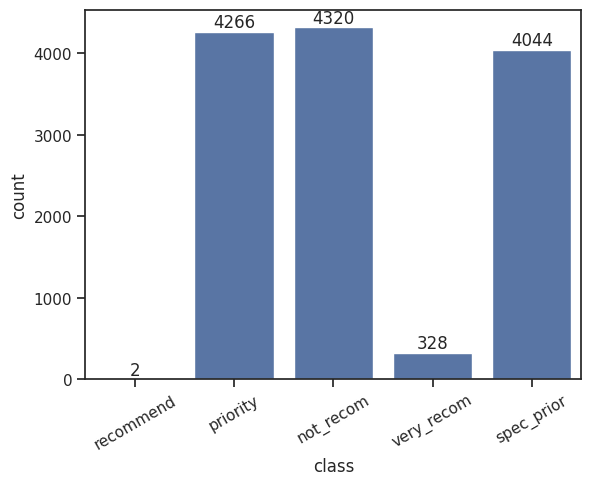

In [5]:
# lets look at the distribution of labels
# print(data_y)
g = sns.countplot(x='class', data=data_y) #data[:,-1])
g.tick_params(axis='x', rotation=30)
g.bar_label(g.containers[0])


### count of samples with 'recommend' as labels is only two. This may pose a constraint during classification  as the train set may not have these two samples have for training.

## split the dataset into train, test, val

In [6]:
def split_train_test_val(data, train_ratio=0.70, test_ratio=0.15):
  val_ratio = 1-(train_ratio+test_ratio)
  train, eval = train_test_split(data, train_size=train_ratio, random_state=101)
  balance = 1-train_ratio
  new_test_ratio = test_ratio/balance
  test, val = train_test_split(eval, test_size = new_test_ratio, random_state=101)

  # print("train.shape", train.shape)
  # print("test.shape", test.shape)
  # print("val.shape", val.shape)


  X_train = train[:,:-1]
  y_train = np.expand_dims(train[:,-1],1)

  # print("X_train.shape", X_train.shape)
  # print("y_train.shape", y_train.shape)

  X_test = test[:,:-1]
  y_test = np.expand_dims(test[:,-1],1)

  X_val = val[:,:-1]
  y_val = np.expand_dims(val[:,-1],1)
  return X_train, X_test, X_val, y_train, y_test, y_val




X_train, X_test, X_val, y_train, y_test, y_val = split_train_test_val(data)


# Task 1: [40 points]
Let’s consider the classification problem in https://archive.ics.uci.edu/dataset/76/nursery, which is a 8-features, 3-classes dataset. It is mentioned in the link that the expected performance of over 90% accuracy (See Baseline Model Performance). Let’s add the following model performance outcomes to the baselines, shall we?

# 1. Decision Tree (categorical features)

## encode the data using
* **ordinal encoder**  for features and
* **label encoder** for labels

In [7]:


# Ordinal Encoding for categorical features
input_encoder = OrdinalEncoder()

# Apply Ordinal Encoding to the features and Label Binarizer to the target labels
X_train_encoded = input_encoder.fit_transform(X_train)
X_val_encoded = input_encoder.transform(X_val)
X_test_encoded = input_encoder.transform(X_test)

# Label encoder for the target labels
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train.flatten())
y_val_encoded = label_encoder.transform(y_val.flatten())
y_test_encoded = label_encoder.transform(y_test.flatten())

print(X_train_encoded)
print(y_train_encoded)



[[1. 0. 2. ... 1. 2. 1.]
 [0. 2. 3. ... 1. 2. 1.]
 [2. 4. 3. ... 0. 2. 1.]
 ...
 [1. 4. 1. ... 1. 2. 0.]
 [2. 2. 3. ... 1. 0. 0.]
 [2. 2. 2. ... 1. 1. 0.]]
[3 1 3 ... 0 0 0]


## setup the search grid parameter



In [8]:

# develop param grid
param_grid = {
    'criterion': ['gini', 'entropy'],        # Splitting criterion
    'splitter': ['best', 'random'],
    'max_depth': [3, 10, 20, 30],         # Maximum depth of the tree
    # 'min_samples_split': [2, 10, 20],        # Minimum samples to split an internal node
    'min_samples_leaf': [1, 5, 10]
}



## create a method for evaluating average performance of classifier

In [9]:
# create a method for evaluating average performance of classifier
def get_classifier_performance(estimator, X_train, y_train, X_test, y_test, X_val, y_val, param_grid, default_classifier_arg=None, trials = 5, cv=2, n_jobs=-1, verbose=0, scoring='accuracy'):

  perf_ls = []

  for trial in range(trials):

    # Initialize the Classifier
    dt = estimator()


    print(f'running {estimator}, trial :{trial}')
    # Set up GridSearchCV to find the best parameters
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring )

    # Fit the model
    grid_search.fit(X_val, y_val)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters: {best_params}")

    # Train the final model on the training set using the best parameters
    best_model = dt.set_params(**best_params)
    best_model.fit(X_train, y_train)

    # Evaluate performance using the best estimator
    # X_test = test[:,:-1]
    # y_test = np.expand_dims(test[:,-1],1)
    y_pred = best_model.predict(X_test)

    # Measure performance
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # store performance
    perf={}
    perf["accuracy"]= accuracy
    perf["precision"]= precision
    # perf["recall"]= recall
    # perf["f1"]= f1
    perf_ls.append(perf)
    print("accuracy=", accuracy)

  # calculate average performance and return result
  _perf = pd.DataFrame(perf_ls)
  _mean = _perf.mean()
  _var = _perf.var()
  _mean =(_mean.rename(lambda x: x+"_mean")).to_dict()
  _var = (_var.rename(lambda x: x+"_var")).to_dict()
  res = {**_mean, **_var}
  # print(_mean)
  # print(_var)
  # print(res)
  return res



## run decision tree classifier algorithm for 5 times and store the mean value of precision, accuracy and other metrics

In [10]:
compare_models = []

# run decision for 5 times and store the mean value of precision, accuracy and other metrics
model = DecisionTreeClassifier

result = get_classifier_performance(model, X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded, X_val_encoded, y_val_encoded, param_grid, trials=5)

result["model"] = "DecisionTree"

compare_models.append(result)

# print(compare_models)


running <class 'sklearn.tree._classes.DecisionTreeClassifier'>, trial :0
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'splitter': 'best'}
accuracy= 0.992798353909465
running <class 'sklearn.tree._classes.DecisionTreeClassifier'>, trial :1
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'splitter': 'best'}
accuracy= 0.9933127572016461
running <class 'sklearn.tree._classes.DecisionTreeClassifier'>, trial :2
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'splitter': 'best'}
accuracy= 0.9933127572016461
running <class 'sklearn.tree._classes.DecisionTreeClassifier'>, trial :3
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'splitter': 'best'}
accuracy= 0.9943415637860082
running <class 'sklearn.tree._classes.DecisionTreeClassifier'>, trial :4
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'spli

# 2. Decision Tree (categorical features in one-hot encoded form)

## Encode the data using One hot encoder

In [11]:
# encode the data

# One Hot Encoding for categorical features
input_encoder = OneHotEncoder()

# Apply Ordinal Encoding to the features and Label Binarizer to the target labels
X_train_encoded = input_encoder.fit_transform(X_train)
X_val_encoded = input_encoder.transform(X_val)
X_test_encoded = input_encoder.transform(X_test)

# Label encoder for the target labels
label_encoder = LabelBinarizer()

y_train_encoded = label_encoder.fit_transform(y_train.flatten())
y_val_encoded = label_encoder.transform(y_val.flatten())
y_test_encoded = label_encoder.transform(y_test.flatten())



## setup the search grid parameter

In [12]:
# Set the hyperparameter grid for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

## run decision tree classifier algorithm (with one hot encoding) for 5 times and store the mean value of precision, accuracy and other metrics

In [13]:
model = DecisionTreeClassifier
result = get_classifier_performance(model, X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded, X_val_encoded, y_val_encoded, param_grid, trials=5)

result["model"] = "DecisionTree-OneHotEncoding"

compare_models.append(result)

running <class 'sklearn.tree._classes.DecisionTreeClassifier'>, trial :0
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy= 0.9969135802469136
running <class 'sklearn.tree._classes.DecisionTreeClassifier'>, trial :1
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy= 0.9974279835390947
running <class 'sklearn.tree._classes.DecisionTreeClassifier'>, trial :2
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy= 0.9974279835390947
running <class 'sklearn.tree._classes.DecisionTreeClassifier'>, trial :3
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
accuracy= 0.9948559670781894
running <class 'sklearn.tree._classes.DecisionTreeClassifier'>,

# Logistic Regression with L1 regularization

## setup search grid parameter

In [14]:
param_grid = {
    'penalty':['l1'],
    'solver':['saga'],
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'max_iter': [10, 100, 1000],
}

## use the same one hot encoding  and label encoder which was used  earlier

In [15]:
# encode the data

# One Hot Encoding for categorical features
input_encoder = OneHotEncoder()

# Apply Ordinal Encoding to the features and Label Binarizer to the target labels
X_train_encoded = input_encoder.fit_transform(X_train)
X_val_encoded = input_encoder.transform(X_val)
X_test_encoded = input_encoder.transform(X_test)

# Label encoder for the target labels
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train.flatten())
y_val_encoded = label_encoder.transform(y_val.flatten())
y_test_encoded = label_encoder.transform(y_test.flatten())



## run logitic regression - L1 (with one hot encoding) for 5 times and store the mean value of precision, accuracy and other metrics

In [16]:
model = LogisticRegression
result = get_classifier_performance(model, X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded, X_val_encoded, y_val_encoded, param_grid, trials=5)

result["model"] = "Logistic Regression L1"

compare_models.append(result)

running <class 'sklearn.linear_model._logistic.LogisticRegression'>, trial :0
Best Hyperparameters: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
accuracy= 0.9259259259259259
running <class 'sklearn.linear_model._logistic.LogisticRegression'>, trial :1
Best Hyperparameters: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
accuracy= 0.9259259259259259
running <class 'sklearn.linear_model._logistic.LogisticRegression'>, trial :2
Best Hyperparameters: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
accuracy= 0.9259259259259259
running <class 'sklearn.linear_model._logistic.LogisticRegression'>, trial :3
Best Hyperparameters: {'C': 10.0, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga'}
accuracy= 0.9228395061728395
running <class 'sklearn.linear_model._logistic.LogisticRegression'>, trial :4
Best Hyperparameters: {'C': 10.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
accuracy= 0.9259259259259259


# k-Nearest Neighbors


## setup search grid parameter

In [17]:
param_grid = {
    'n_neighbors': [ 9, 11], #3, 5, 7,       # Number of neighbors to use
    'weights': ['uniform', 'distance'],    # Weight function for neighbors
    'p': [2],   #1,                          # Power parameter for Minkowski metric (1 for Manhattan, 2 for Euclidean)
}

In [18]:
# encode the data

# One Hot Encoding for categorical features
input_encoder = OneHotEncoder()

# Apply Ordinal Encoding to the features and Label Binarizer to the target labels
X_train_encoded = input_encoder.fit_transform(X_train)
X_val_encoded = input_encoder.transform(X_val)
X_test_encoded = input_encoder.transform(X_test)

# Label encoder for the target labels
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train.flatten())
y_val_encoded = label_encoder.transform(y_val.flatten())
y_test_encoded = label_encoder.transform(y_test.flatten())



In [19]:
model = KNeighborsClassifier
result = get_classifier_performance(model, X_train_encoded, y_train_encoded, X_test_encoded, y_test_encoded, X_val_encoded, y_val_encoded, param_grid, trials=5)

result["model"] = "K-nearest neighbours"

compare_models.append(result)

running <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, trial :0
Best Hyperparameters: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
accuracy= 0.9593621399176955
running <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, trial :1
Best Hyperparameters: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
accuracy= 0.9593621399176955
running <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, trial :2
Best Hyperparameters: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
accuracy= 0.9593621399176955
running <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, trial :3
Best Hyperparameters: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
accuracy= 0.9593621399176955
running <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, trial :4
Best Hyperparameters: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
accuracy= 0.9593621399176955


In [20]:
chart_data1 = pd.DataFrame(compare_models)
chart_data1['accuracy_mean'] = chart_data1['accuracy_mean'] *100
chart_data1['precision_mean'] = chart_data1['precision_mean'] *100
chart_data1['accuracy_var'] = chart_data1['accuracy_var'] *100
chart_data1['precision_var'] = chart_data1['precision_var'] *100

print(chart_data1)

   accuracy_mean  precision_mean  accuracy_var  precision_var  \
0      99.331276       99.480201      0.000040       0.000024   
1      99.639918       79.775393      0.000146       0.000056   
2      92.530864       87.716499      0.000191       0.000006   
3      95.936214       95.875690      0.000000       0.000000   

                         model  
0                 DecisionTree  
1  DecisionTree-OneHotEncoding  
2       Logistic Regression L1  
3         K-nearest neighbours  


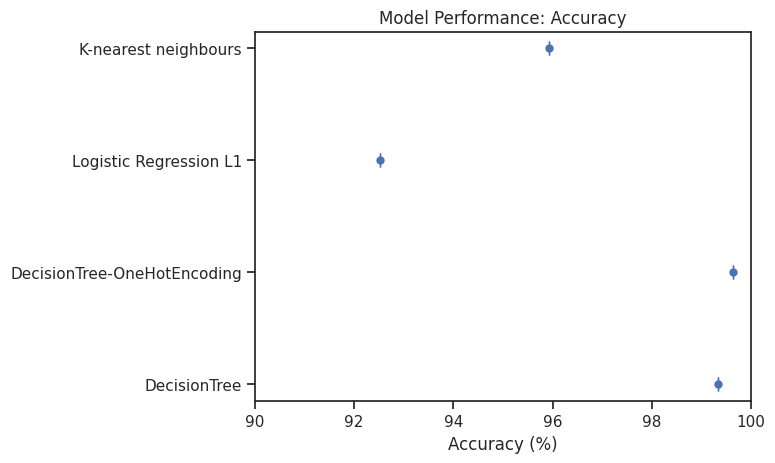

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Calculate the standard deviation from variance
chart_data1['accuracy_std'] = chart_data1['accuracy_var'] ** 0.5
chart_data1['precision_std'] = chart_data1['precision_var'] ** 0.5


fig, ax = plt.subplots()

# Horizontal error bars
ax.errorbar(chart_data1["accuracy_mean"], chart_data1["model"], xerr=chart_data1["accuracy_var"], fmt='o', markersize=5, capsize=5)

# Labels and title
ax.set_xlabel('Accuracy (%)')
ax.set_title('Model Performance: Accuracy')

# Set the x-axis limits to reflect the accuracy range
plt.xlim([90, 100])

# Show plot
plt.show()

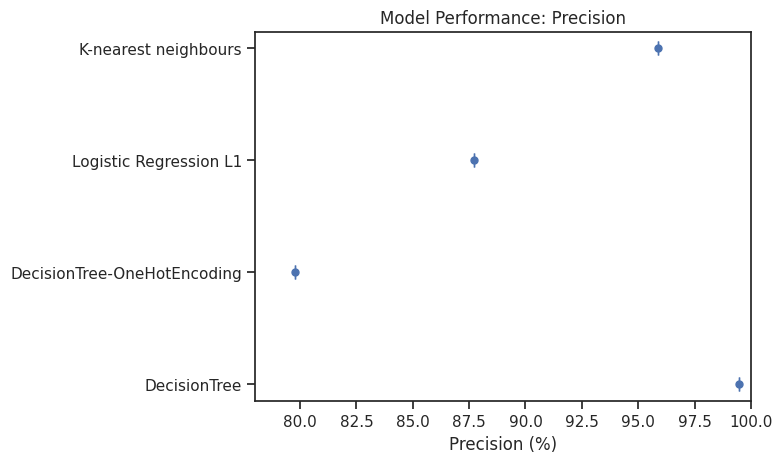

In [22]:
fig, ax = plt.subplots()

# Horizontal error bars
ax.errorbar(chart_data1["precision_mean"], chart_data1["model"], xerr=chart_data1["precision_var"], fmt='o', markersize=5, capsize=5)

# Labels and title
ax.set_xlabel('Precision (%)')
ax.set_title('Model Performance: Precision')

# Set the x-axis limits to reflect the accuracy range
plt.xlim([78, 100])

# Show plot
plt.show()

## List the baseline performance of other 5 methods source(https://archive.ics.uci.edu/dataset/76/nursery)

add the performance data to the list for making comparison chart

In [23]:
compare_5_models = []
# XGBoost Performance:
# Accuracy - Mean: 0.99969, Variance: 0.00093 (.99907-1)
# Precision - Mean: 0.99976, Variance: 0.00074 (.99926-1)

compare_5_models.append({'model': "XGBoost" , 'accuracy_mean':99.969,  'precision_mean':99.976,  'accuracy_var':0.00093 , 'precision_var':0.00074  })

# SVM Performance:
# Accuracy - Mean: 0.99198, Variance: 0.00468 (.99127-.99595)
# Precision - Mean: 0.99367, Variance: 0.00475 (0.99120-0.99595)

compare_5_models.append({'model': "SVM" , 'accuracy_mean':99.198,  'precision_mean':99.367,  'accuracy_var':0.00468 , 'precision_var':0.00475  })

# Random Forest Performance:
# Accuracy - Mean: 0.98025, Variance: 0.00957 (.97531-.98488)
# Precision - Mean: 0.97473, Variance: 0.02434(.96113-.98547)

compare_5_models.append({'model': "Random Forest" , 'accuracy_mean':98.025,  'precision_mean':97.473,  'accuracy_var':0.00957 , 'precision_var':0.02434  })

# NN Performance:
# Accuracy - Mean: 1.0, Variance: 0.0
# Precision - Mean: 1.0, Variance: 0.0

compare_5_models.append({'model': "NN" , 'accuracy_mean':100,  'precision_mean':100,  'accuracy_var':0.0 , 'precision_var':0.0  })

# Logistic Regresssion Performance:
# Accuracy - Mean: 0.92253, Variance: 0.0179 (.91327-0.93117)
# Precision - Mean: 0.91868, Variance: 0.03997(0.89713-0.93710)

compare_5_models.append({'model': "Logistic Regression" , 'accuracy_mean':92.253,  'precision_mean':91.868,  'accuracy_var':0.0179 , 'precision_var':0.03997  })


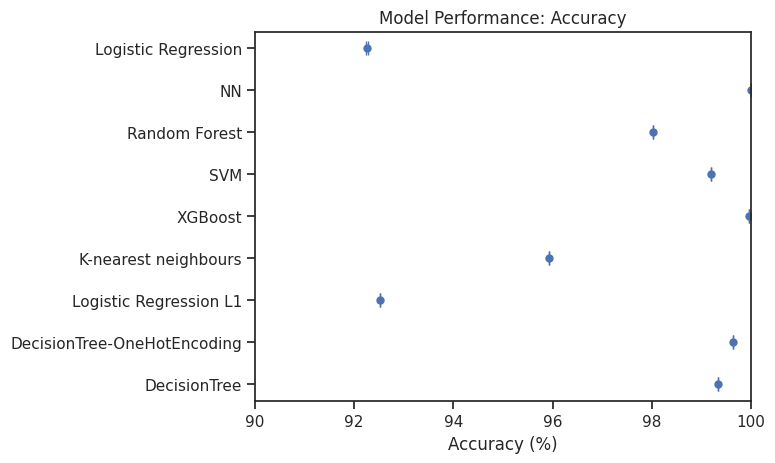

In [24]:
chart_data2 = pd.DataFrame(compare_5_models)

chart_data3 = pd.concat([chart_data1, chart_data2])

fig, ax = plt.subplots()

# Horizontal error bars
ax.errorbar(chart_data3["accuracy_mean"], chart_data3["model"], xerr=chart_data3["accuracy_var"], fmt='o', markersize=5, capsize=5)

# Labels and title
ax.set_xlabel('Accuracy (%)')
ax.set_title('Model Performance: Accuracy')

# Set the x-axis limits to reflect the accuracy range
plt.xlim([90, 100])

# Show plot
plt.show()

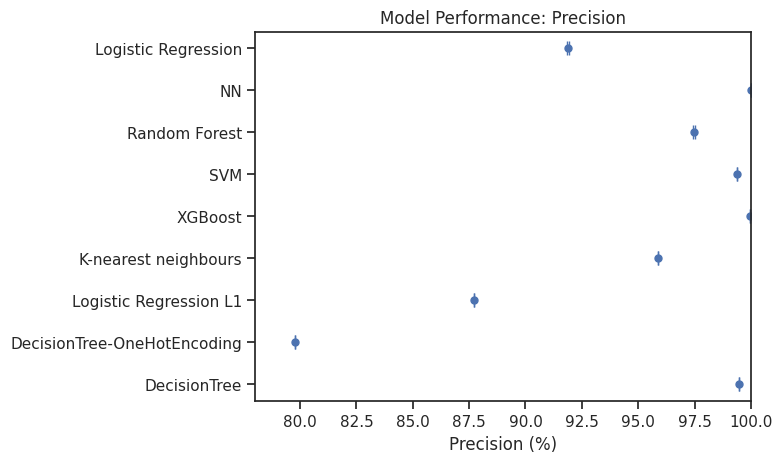

In [25]:
fig, ax = plt.subplots()

# Horizontal error bars
ax.errorbar(chart_data3["precision_mean"], chart_data3["model"], xerr=chart_data3["precision_var"], fmt='o', markersize=5, capsize=5)

# Labels and title
ax.set_xlabel('Precision (%)')
ax.set_title('Model Performance: Precision')

# Set the x-axis limits to reflect the accuracy range
plt.xlim([78, 100])

# Show plot
plt.show()

#Task 2: [10 points]
You may notice that the shape of logistic regression decision boundary and a sigmoid are a look-alike. We know that range of sigmoid is 0 to 1, which means, we can use sigmoid only when outputs are unipolar. Here are some simple extensions, we may try.
# 1. Construct a bipolar_sigmoid(x) using unipolar sigmoid.

In [27]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def bipolar_sigmoid(x):
    return 2 * sigmoid(x) - 1

# 2. A popular bipolar normalizer is tanh(x). Compare the reponse of tanh(x) vs your bipolar_sigmoid(x).


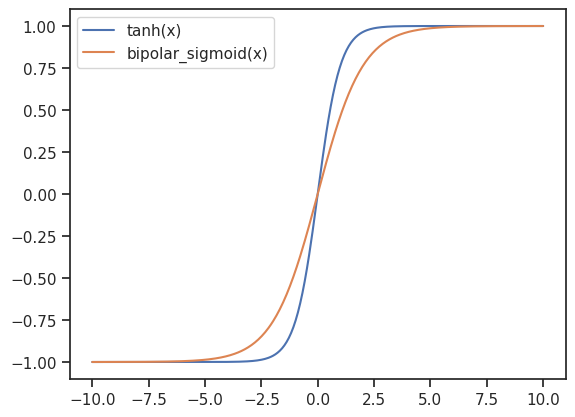

In [28]:
x = np.linspace(-10, 10, 400)
y_tanh = np.tanh(x)
y_bipolar_sigmoid = bipolar_sigmoid(x)

plt.plot(x, y_tanh, label='tanh(x)')
plt.plot(x, y_bipolar_sigmoid, label='bipolar_sigmoid(x)')
plt.legend()
plt.show()

# 3. Parameterize it as bipolar_sigmoid(ax), tanh(ax); You may plot the shapes of the response at different values of ‘a’ in [-5, -1, -.1, -.01, .001, .01, .1, 1, 5].


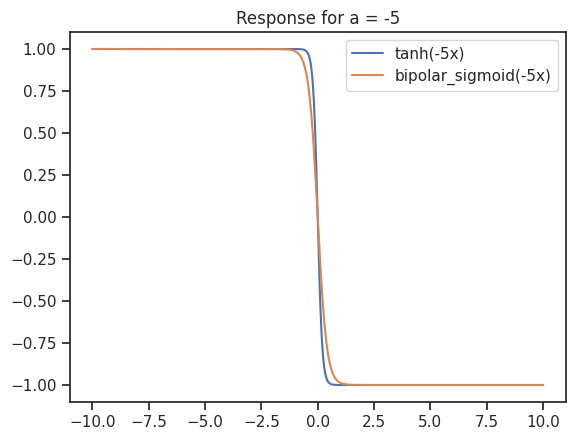

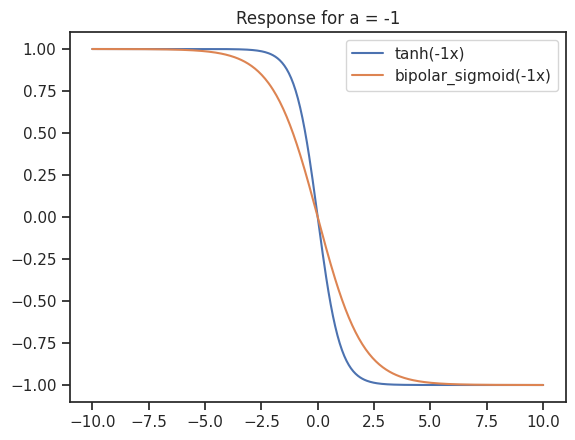

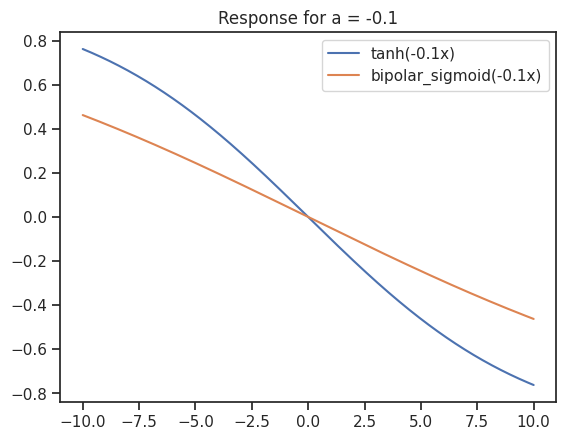

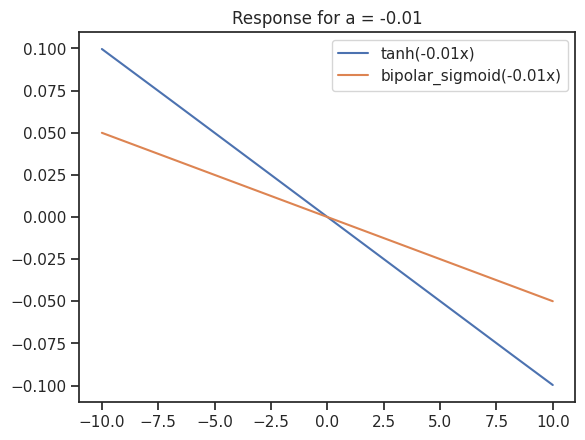

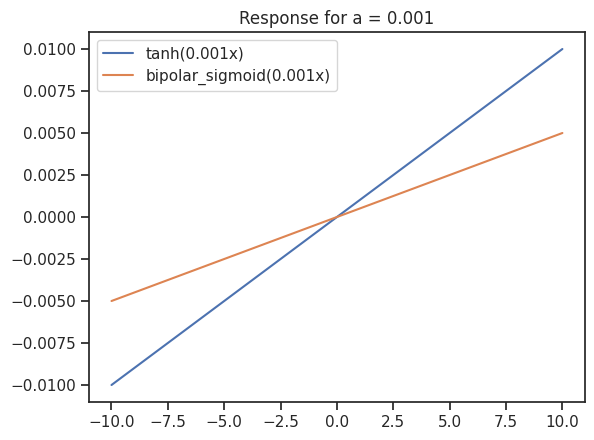

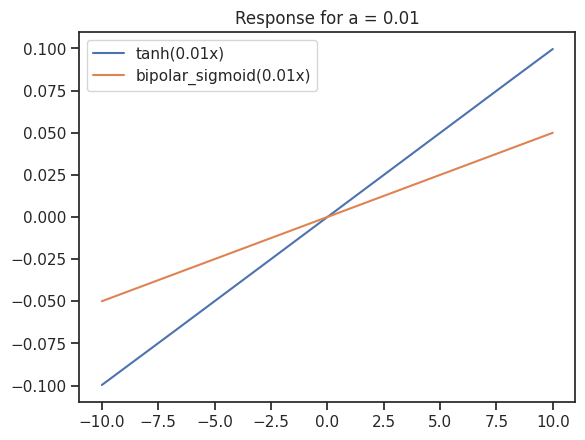

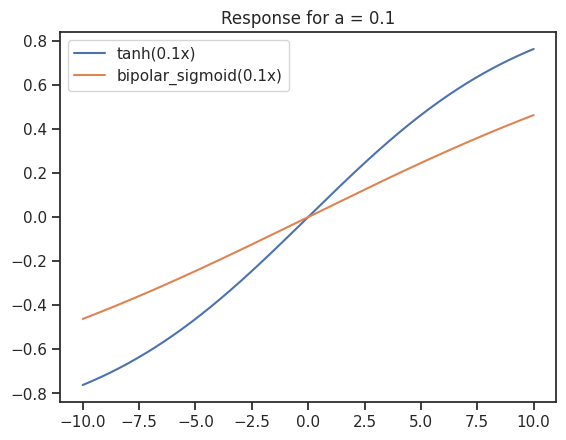

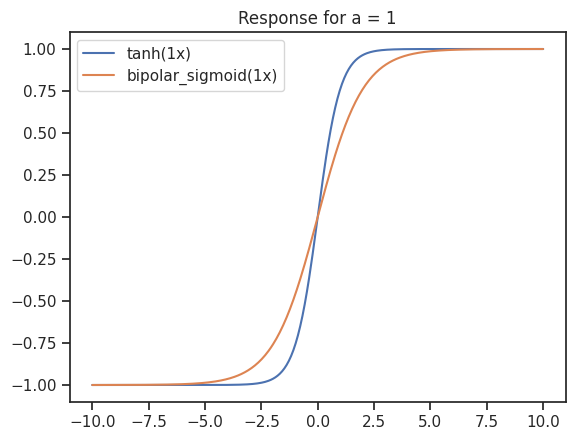

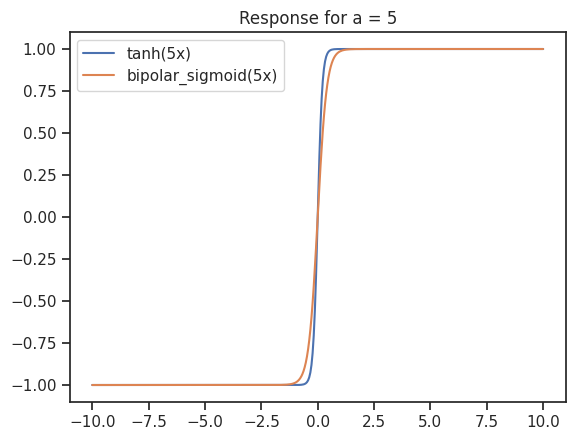

In [29]:
a_values = [-5, -1, -0.1, -0.01, 0.001, 0.01, 0.1, 1, 5]

for a in a_values:
    y_tanh_a = np.tanh(a * x)
    y_bipolar_sigmoid_a = bipolar_sigmoid(a * x)

    plt.plot(x, y_tanh_a, label=f'tanh({a}x)')
    plt.plot(x, y_bipolar_sigmoid_a, label=f'bipolar_sigmoid({a}x)')
    plt.legend()
    plt.title(f'Response for a = {a}')
    plt.show()

# Inference :
When  a is small, the function is more spread out, and the linear region extends over a larger range of  x.
When a is large, the sigmoid function becomes steeper, and the linear region is narrower.


# 4. Now comes the interesting part. Can you evaluate the linear range of ‘x’ for each value of ‘a’ in bipolar_sigmoid(ax)? Usually, when ‘a’ is small, the linearity range is high.

linear range can be considered as  the range of
$x$ where the bipolar sigmoid, $σ(x)$ is close to its linear approximation. This can be done by checking when $σ(x)$ deviates significantly (e.g., by more than a certain percentage say 5%) from the linear approximation $ax$.

In [31]:

# Define the linear approximation
def linear_approximation(a, x):
    return a * x

# Define the tolerance for deviation from the linear approximation
tolerance = 0.05  # 5% deviation

# Values of 'a' as given in the problem
a_values = [-5, -1, -0.1, -0.01, 0.001, 0.01, 0.1, 1, 5]

# X values to evaluate (small range around zero)
x_values = np.linspace(-2, 2, 1000)

# Function to compute the linear range for each 'a'
def find_linear_range(a):
    for x in x_values:
        sigmoid_value = bipolar_sigmoid(a* x)
        linear_value = linear_approximation(a, x)
        if np.abs(sigmoid_value - linear_value) / np.abs(linear_value) > tolerance:
            return -x, x  # symmetric range around zero
    return -2, 2  # If no significant deviation is found within the given range

# Compute linear ranges for each value of 'a'
linear_ranges = {a: find_linear_range(a) for a in a_values}
linear_ranges

{-5: (2.0, -2.0),
 -1: (2.0, -2.0),
 -0.1: (2.0, -2.0),
 -0.01: (2.0, -2.0),
 0.001: (2.0, -2.0),
 0.01: (2.0, -2.0),
 0.1: (2.0, -2.0),
 1: (2.0, -2.0),
 5: (2.0, -2.0)}

# Result
> For all values of $a$ in the given range, the bipolar sigmoid function remains close to its linear approximation within the range
$𝑥 ∈[−2,2]$.

This indicates that, for this specific tolerance of $5$% deviation, the function behaves approximately linearly within this interval for all values of $𝑎$